## Additional Analysis: QQ Plots
Summary: QQ plots are used to compare the distribution of a dataset to a normal
distribution. If the dataset is normally distributed, the points should fall along a
straight line. If the points deviate from the line, it indicates a deviation from
normality.

Also, QQ plots can be used to compare the distributions of two datasets,
including the Kolmogorov-Smirnov test to check if the distributions are significantly
different. Finally we can use the Shapiro-Wilk test to check if a dataset is normally
distributed.
Finally, QQ plats can tell us if thhe tail behaviour of the two distributions is
similar or not, if one is more extreme moves than the otehter, etc
And whether they may be driven by similar underlying factors.

In [11]:
import glob
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import scipy.stats as stats
import seaborn as sns

# Set style for better visualizations
sns.set_theme()
plt.rcParams["figure.figsize"] = [12, 6]

## Load and Prepare Data

In [16]:
def load_and_prepare_data(data_dir="../data/processed/"):
    returns_data = {}

    for file in glob.glob(os.path.join(data_dir, "*.parquet")):
        symbol = os.path.basename(file).split("_")[0]
        df = pq.read_table(file).to_pandas()

        # Calculate log returns
        df["log_returns"] = np.log(df["close"]).diff()
        returns_data[symbol] = df["log_returns"].dropna()

    return returns_data

## QQ Plots vs Normal Distribution

In [17]:
def plot_qq_normal(returns_data):
    """Create QQ plots comparing each cryptocurrency's returns to normal distribution."""
    n_symbols = len(returns_data)
    n_cols = 2
    n_rows = (n_symbols + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle("QQ Plots vs Normal Distribution", fontsize=16, y=1.02)

    # Flatten axes for easier iteration
    if n_rows > 1:
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes] if n_cols == 1 else axes

    for (symbol, returns), ax in zip(returns_data.items(), axes_flat):
        # Standardize returns
        standardized_returns = (returns - returns.mean()) / returns.std()

        # Create QQ plot
        stats.probplot(standardized_returns, dist="norm", plot=ax)
        ax.set_title(f"{symbol} Returns vs Normal Distribution")

        # Calculate and display Shapiro-Wilk test
        stat, p_value = stats.shapiro(standardized_returns)
        ax.text(
            0.05,
            0.95,
            f"Shapiro-Wilk p-value: {p_value:.2e}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
        )

    # Remove empty subplots if any
    for idx in range(len(returns_data), len(axes_flat)):
        fig.delaxes(axes_flat[idx])

    plt.tight_layout()
    plt.show()

## QQ Plots Between Pairs of Cryptocurrencies

In [18]:
def plot_qq_pairs(returns_data):
    """Create QQ plots comparing returns distributions between pairs of cryptocurrencies."""
    pairs = list(itertools.combinations(returns_data.keys(), 2))
    n_pairs = len(pairs)
    n_cols = 2
    n_rows = (n_pairs + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle("QQ Plots Between Cryptocurrency Pairs", fontsize=16, y=1.02)

    # Flatten axes for easier iteration
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for (symbol1, symbol2), ax in zip(pairs, axes_flat):
        returns1 = returns_data[symbol1]
        returns2 = returns_data[symbol2]

        # Standardize both return series
        std_returns1 = (returns1 - returns1.mean()) / returns1.std()
        std_returns2 = (returns2 - returns2.mean()) / returns2.std()

        # Get common length
        min_len = min(len(std_returns1), len(std_returns2))
        std_returns1 = std_returns1[:min_len]
        std_returns2 = std_returns2[:min_len]

        # Sort both series
        sorted1 = np.sort(std_returns1)
        sorted2 = np.sort(std_returns2)

        # Create QQ plot
        ax.scatter(sorted1, sorted2, alpha=0.5)

        # Add diagonal line
        min_val = min(sorted1.min(), sorted2.min())
        max_val = max(sorted1.max(), sorted2.max())
        ax.plot([min_val, max_val], [min_val, max_val], "r--")

        ax.set_title(f"QQ Plot: {symbol1} vs {symbol2}")
        ax.set_xlabel(f"{symbol1} Standardized Returns")
        ax.set_ylabel(f"{symbol2} Standardized Returns")

        # Calculate and display Kolmogorov-Smirnov test
        ks_stat, p_value = stats.ks_2samp(std_returns1, std_returns2)
        ax.text(
            0.05,
            0.95,
            f"KS test p-value: {p_value:.2e}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
        )

    # Remove empty subplots if any
    for idx in range(len(pairs), len(axes_flat)):
        fig.delaxes(axes_flat[idx])

    plt.tight_layout()
    plt.show()

## Run Analysis

QQ Plots vs Normal Distribution


/home/nfiroo/base_venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44640.
  res = hypotest_fun_out(*samples, **kwds)


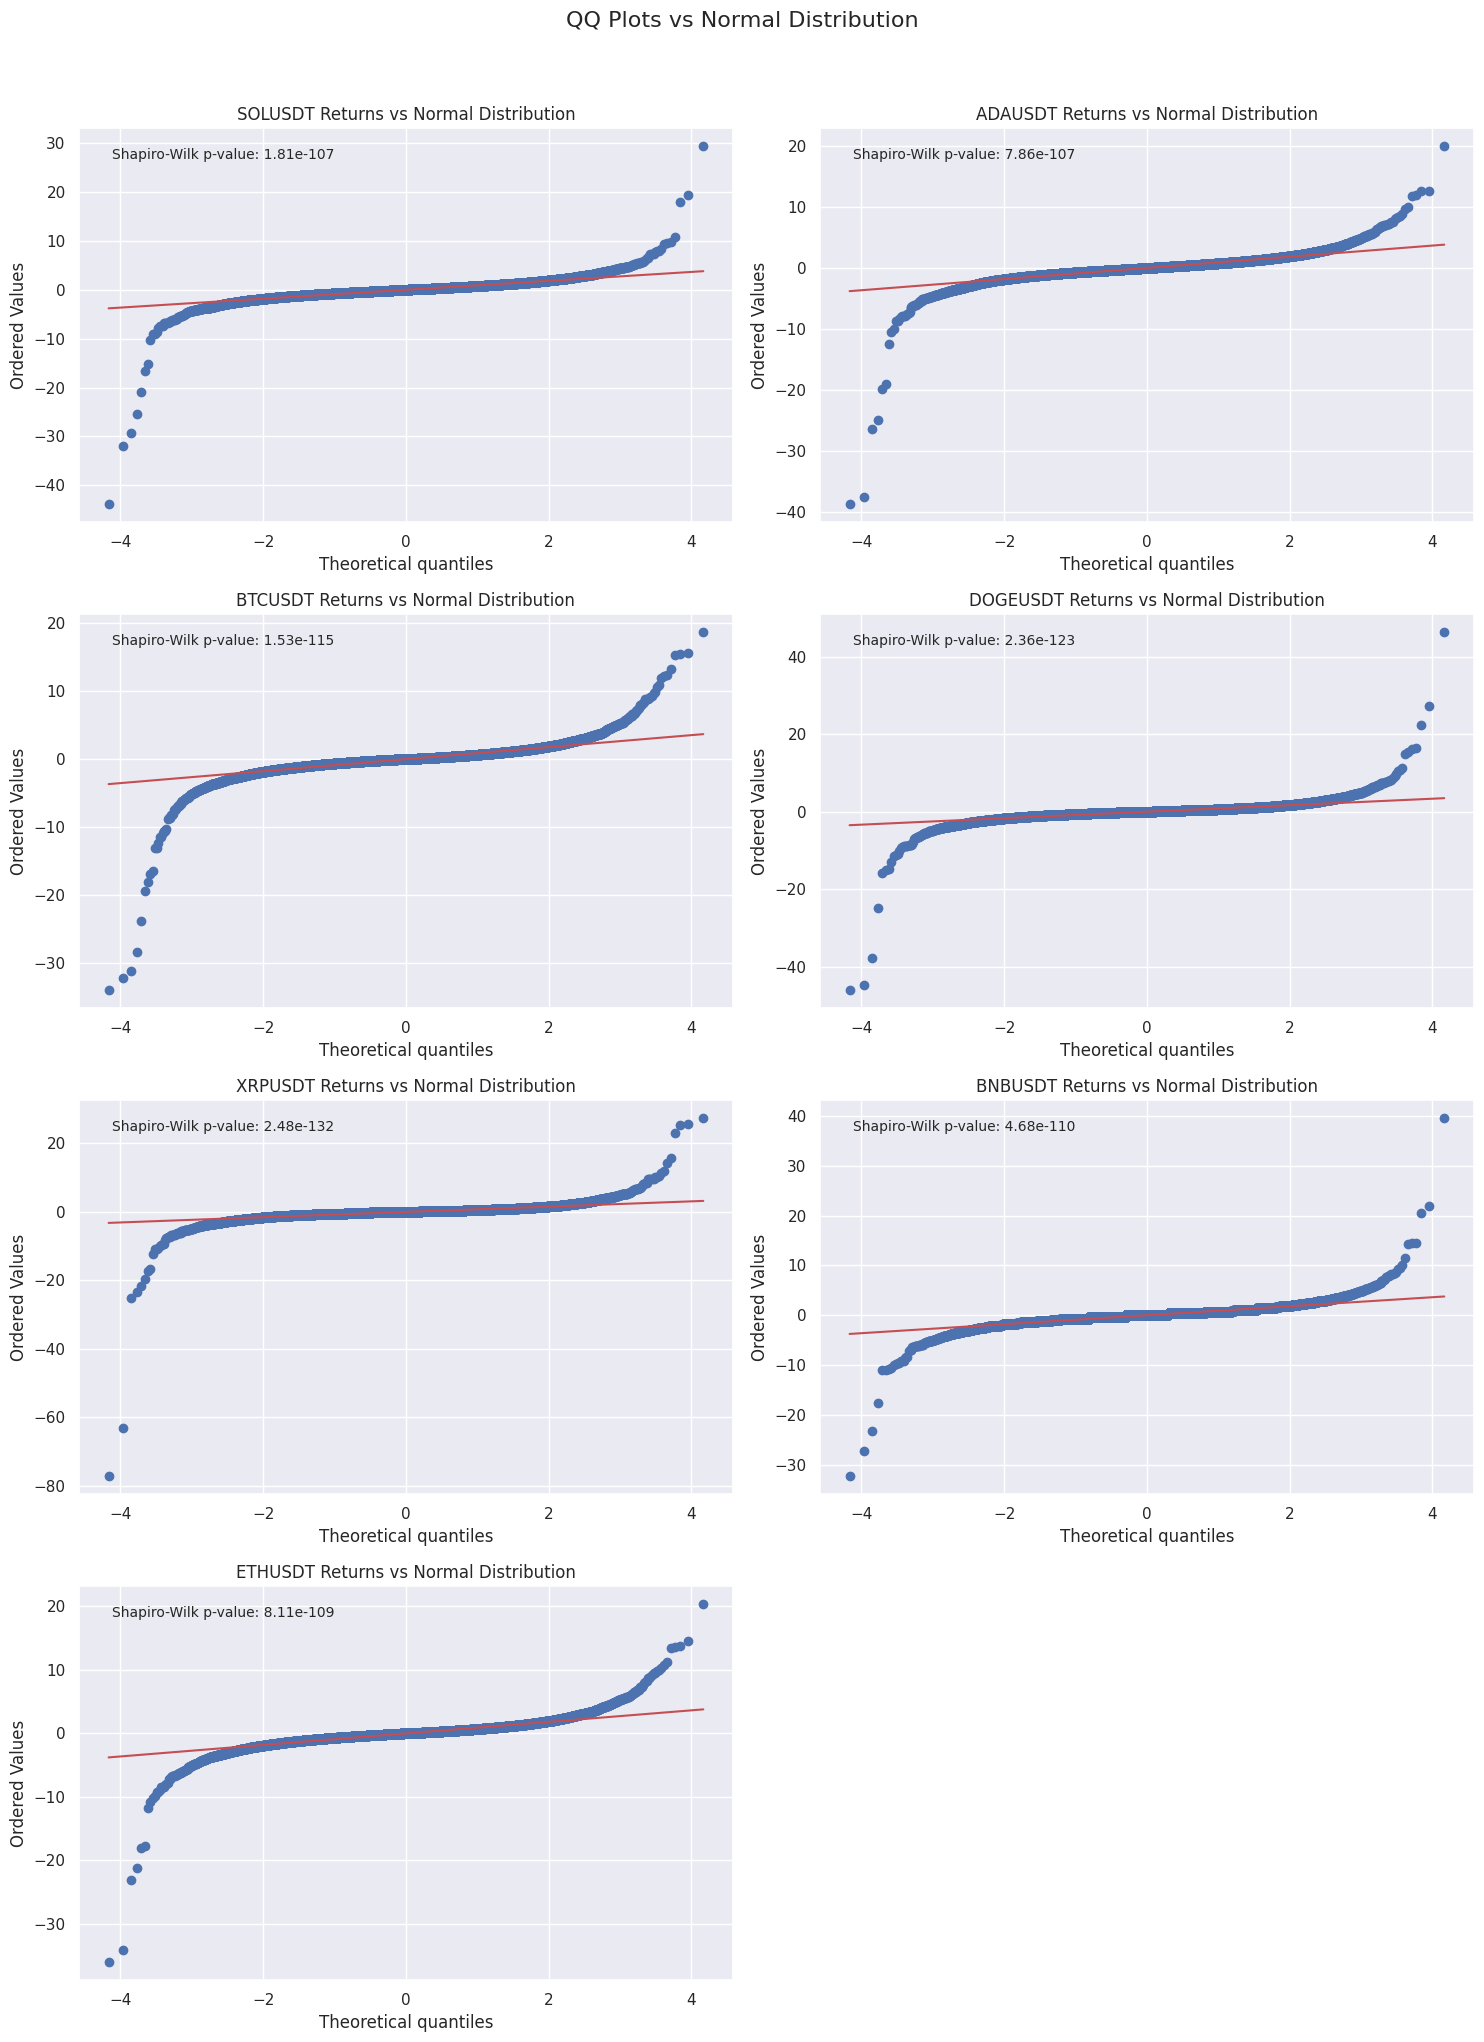

In [20]:
# Load data
returns_data = load_and_prepare_data()

# Plot QQ plots vs normal distribution
print("QQ Plots vs Normal Distribution")
plot_qq_normal(returns_data)


QQ Plots Between Cryptocurrency Pairs


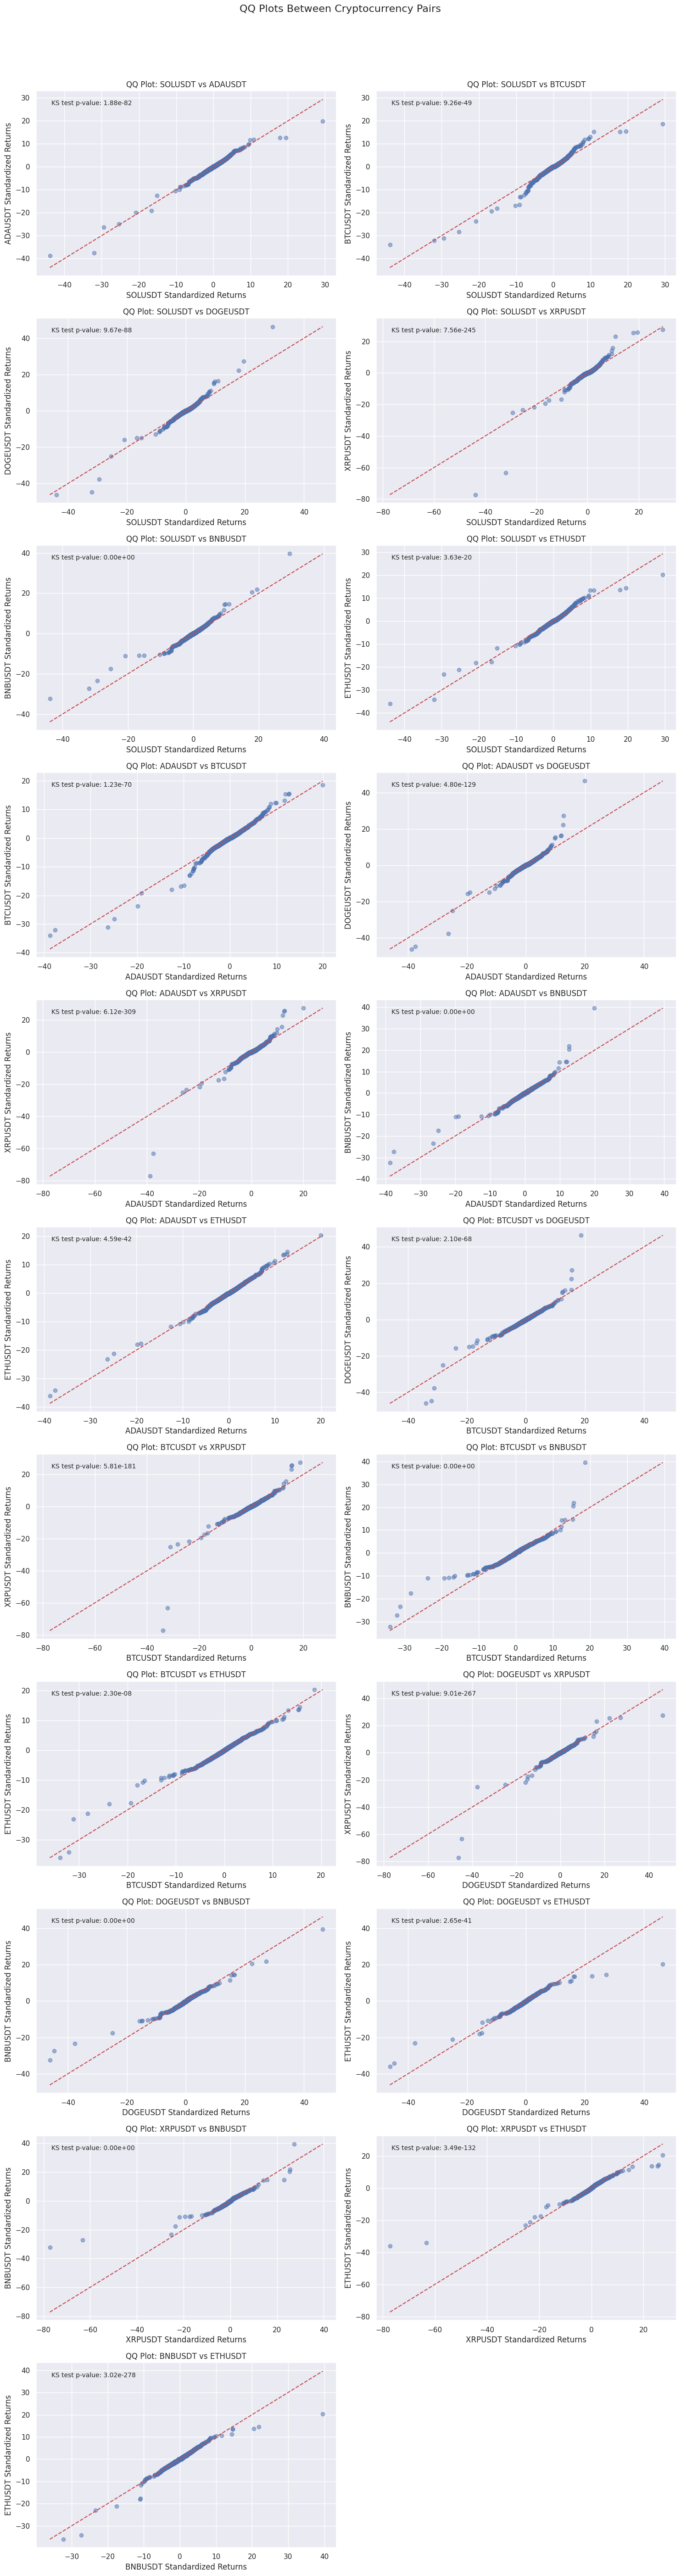

In [21]:
# Plot QQ plots between pairs
print("\nQQ Plots Between Cryptocurrency Pairs")
plot_qq_pairs(returns_data)

## Summary Statistics of Deviations from Normal

In [ ]:
def print_distribution_stats(returns_data):
    """Print summary statistics about the distribution of returns."""
    stats_df = pd.DataFrame(
        columns=["Mean", "Std", "Skewness", "Kurtosis", "Shapiro-Wilk p-value"]
    )

    for symbol, returns in returns_data.items():
        # Standardize returns
        std_returns = (returns - returns.mean()) / returns.std()

        # Calculate statistics
        sw_stat, sw_p = stats.shapiro(std_returns)

        stats_df.loc[symbol] = [
            returns.mean(),
            returns.std(),
            stats.skew(returns),
            stats.kurtosis(returns),  # Fisher kurtosis (normal = 0)
            sw_p,
        ]

    print("\nDistribution Statistics:")
    print(stats_df)


print_distribution_stats(returns_data)